In [122]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [123]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from keras.layers import Dense, MaxPool2D, Conv2D, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Sequential

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Extract Data

In [124]:
import zipfile
train_zip='../input/dogs-vs-cats-redux-kernels-edition/train.zip'
zip_ref=zipfile.ZipFile(train_zip,'r').extractall('./')

test_zip = '../input/dogs-vs-cats-redux-kernels-edition/test.zip'
zip_ref=zipfile.ZipFile(test_zip,'r').extractall('./')


In [125]:
import os
train_filenames = os.listdir('./train')
test_filenames = os.listdir('./test')

In [126]:
# Create DataFrame for ImageDataGenerator
train = pd.DataFrame(columns=['path', 'label'])
train['path'] = train_filenames
train['label'] = train['path'].str[0:3]

In [18]:
train.head()

,path,label
0,dog.8572.jpg,dog
1,cat.11119.jpg,cat
2,dog.2605.jpg,dog
3,dog.10949.jpg,dog
4,cat.8438.jpg,cat


<AxesSubplot:>

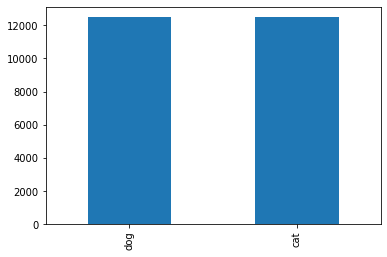

In [19]:
train.label.value_counts().plot.bar() # Balanced Data

In [127]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

In [128]:
width, height = 150, 150
trainDatagen = train_datagen.flow_from_dataframe(train, directory = './train', x_col='path', y_col='label', classes=['cat', 'dog' ],
                                           target_size=(width,height), class_mode = 'categorical', batch_size = 16,
                                           subset='training')

valDatagen = train_datagen.flow_from_dataframe(train, directory = './train', x_col='path', y_col='label', classes=['cat','dog'],
                                           target_size=(width,height), class_mode = 'categorical', batch_size = 16,
                                           subset='validation')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [129]:
x, y = trainDatagen.next()
x.shape, y.shape

((16, 150, 150, 3), (16, 2))

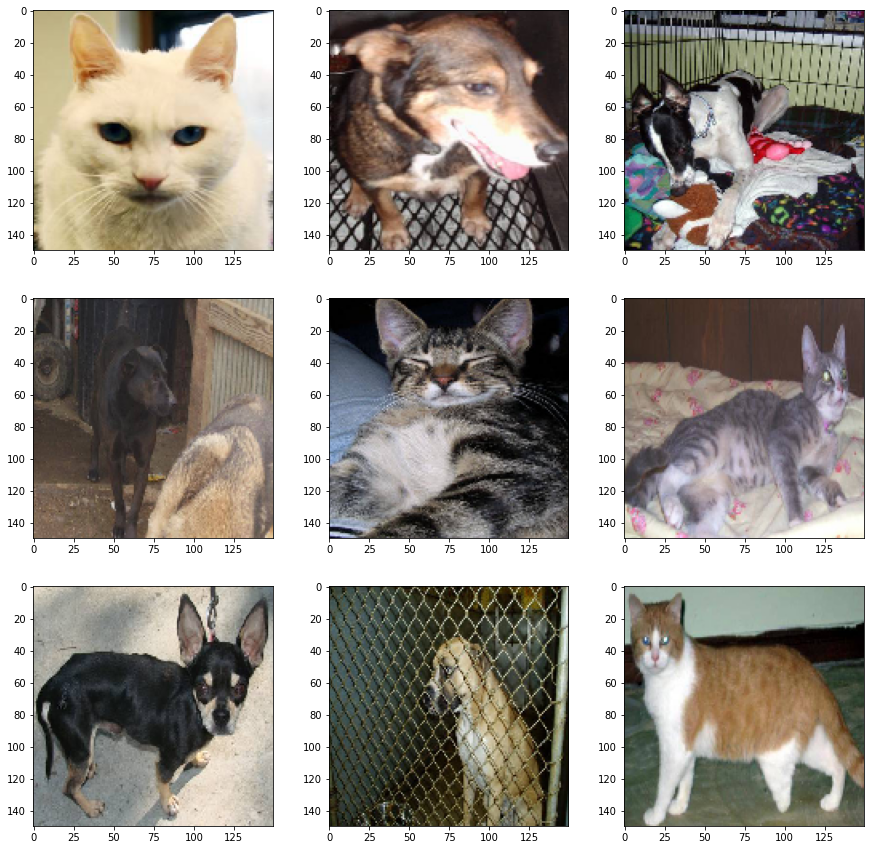

In [23]:
plt.figure(figsize=(15,15))
for i in range(9):
    img, label = trainDatagen.next()
    plt.subplot(331+i)
    plt.imshow(img[0])
plt.show()

## Test Data

In [130]:
test = pd.DataFrame(columns=['path'])
test['path'] = test_filenames
test.head()

,path
0,3647.jpg
1,10636.jpg
2,6141.jpg
3,4444.jpg
4,12067.jpg


In [131]:
test_datagen = ImageDataGenerator(rescale=1/255.0)
width, height = 150, 150
testDatagen = test_datagen.flow_from_dataframe(test, directory = './test', x_col='path', class_mode= None,
                                           target_size=(width,height), batch_size = 16, shuffle=False)

Found 12500 validated image filenames.


## Training and Prediction
### 1.Convolutional network


In [26]:
model = models.Sequential()
model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
 
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
    
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
 
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())

model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(2,activation='softmax'))

model.compile(loss="categorical_crossentropy",optimizer=optimizers.Adam(learning_rate=1e-4),metrics=['acc'])
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 36, 36, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)      

In [27]:
history = model.fit(trainDatagen, steps_per_epoch = len(trainDatagen), epochs=10, validation_data = valDatagen, validation_steps=len(valDatagen), shuffle=True)

Epoch 1/10
1250/1250 [==============================] - 71s 57ms/step - loss: 0.7400 - acc: 0.6664 - val_loss: 0.6850 - val_acc: 0.6780
Epoch 2/10
1250/1250 [==============================] - 71s 57ms/step - loss: 0.5573 - acc: 0.7467 - val_loss: 0.5027 - val_acc: 0.7758
Epoch 3/10
1250/1250 [==============================] - 71s 56ms/step - loss: 0.4519 - acc: 0.7940 - val_loss: 0.5446 - val_acc: 0.7668
Epoch 4/10
1250/1250 [==============================] - 70s 56ms/step - loss: 0.3832 - acc: 0.8287 - val_loss: 0.7856 - val_acc: 0.7088
Epoch 5/10
1250/1250 [==============================] - 70s 56ms/step - loss: 0.3370 - acc: 0.8515 - val_loss: 0.4229 - val_acc: 0.8198
Epoch 6/10
1250/1250 [==============================] - 70s 56ms/step - loss: 0.2885 - acc: 0.8777 - val_loss: 0.3798 - val_acc: 0.8316
Epoch 7/10
1250/1250 [==============================] - 70s 56ms/step - loss: 0.2496 - acc: 0.8967 - val_loss: 0.3734 - val_acc: 0.8424
Epoch 8/10
1250/1250 [==========================

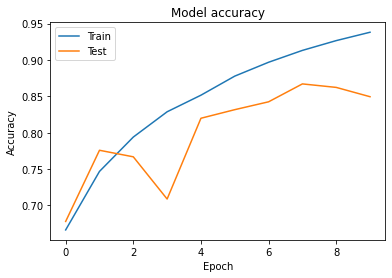

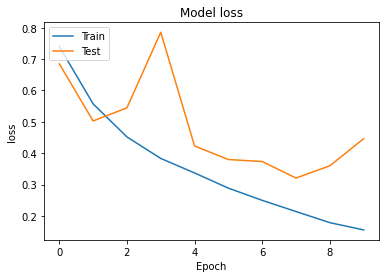

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="upper left")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="upper left")
plt.show()

In [29]:
predictions = model.predict(testDatagen, batch_size=32, verbose =1)
predictions

782/782 [==============================] - 34s 43ms/step


array([[0.98459715, 0.01540291],
       [0.2188291 , 0.78117085],
       [0.11730887, 0.8826912 ],
       ...,
       [0.2563265 , 0.74367356],
       [0.71052134, 0.2894787 ],
       [0.00568918, 0.99431086]], dtype=float32)

In [30]:
submission = pd.read_csv('../input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')
submission['label'] = predictions[:,0]
submission.to_csv('submission_cnn_epoch10.csv', index=False)
submission.head()

,id,label
0,1,0.984597
1,2,0.218829
2,3,0.117309
3,4,0.999933
4,5,0.994507


In [31]:
#### Kaagle score 2.438

### 1.2 Convolutional network with epoch = 15

In [34]:
history = model.fit(trainDatagen, steps_per_epoch = len(trainDatagen), epochs=15, validation_data = valDatagen, validation_steps=len(valDatagen), shuffle=True)

Epoch 1/15
1250/1250 [==============================] - 69s 55ms/step - loss: 0.0247 - acc: 0.9920 - val_loss: 0.5228 - val_acc: 0.8794
Epoch 2/15
1250/1250 [==============================] - 69s 55ms/step - loss: 0.0240 - acc: 0.9917 - val_loss: 0.4884 - val_acc: 0.8766
Epoch 3/15
1250/1250 [==============================] - 69s 55ms/step - loss: 0.0236 - acc: 0.9923 - val_loss: 0.4688 - val_acc: 0.8812
Epoch 4/15
1250/1250 [==============================] - 69s 55ms/step - loss: 0.0239 - acc: 0.9919 - val_loss: 0.4083 - val_acc: 0.8754
Epoch 5/15
1250/1250 [==============================] - 69s 55ms/step - loss: 0.0220 - acc: 0.9922 - val_loss: 0.4797 - val_acc: 0.8810
Epoch 6/15
1250/1250 [==============================] - 69s 55ms/step - loss: 0.0166 - acc: 0.9944 - val_loss: 0.4593 - val_acc: 0.8740
Epoch 7/15
1250/1250 [==============================] - 69s 56ms/step - loss: 0.0216 - acc: 0.9923 - val_loss: 0.6103 - val_acc: 0.8606
Epoch 8/15
1250/1250 [==========================

In [35]:
predictions1 = model.predict(testDatagen, batch_size=32, verbose =1)
predictions1

782/782 [==============================] - 34s 43ms/step


array([[9.9990177e-01, 9.8176890e-05],
       [6.2741935e-01, 3.7258062e-01],
       [6.4969994e-02, 9.3503004e-01],
       ...,
       [8.3999448e-03, 9.9160004e-01],
       [3.0820826e-01, 6.9179171e-01],
       [4.0255695e-06, 9.9999595e-01]], dtype=float32)

In [36]:
submission1 = pd.read_csv('../input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')
submission1['label'] = predictions1[:,0]
submission1.to_csv('submission_ep15_1.csv', index=False)
submission1.head()

,id,label
0,1,0.999902
1,2,0.627419
2,3,0.064970
3,4,0.999930
4,5,0.303635


In [ ]:
## kaggle score 5.44

In [ ]:
##### not run 
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3)))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     directory='my_dir',
                     project_name='intro_to_kt')

tuner.search(train_data, train_labels, epochs=50, validation_data=(val_data, val_labels))


In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3)))
    model.add(Flatten())

    # Tunable parameters
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))  # or 'softmax' for categorical

    # Compile model
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',  # or 'categorical_crossentropy'
        metrics=['accuracy']
    )
    return model


I did try the keres tuner for hyperparameter, however, it took me 4 hours running with results so I would like to modify hyperparameter manually

In [ ]:
import kerastuner as kt

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='my_dir',
    project_name='kt_image_gen'
)


In [ ]:
tuner.search(
    trainDatagen,
    steps_per_epoch=trainDatagen.n // trainDatagen.batch_size,
    epochs=50,
    validation_data=valDatagen,  # if you have a validation generator
    validation_steps=valDatagen.n // valDatagen.batch_size
)


In [ ]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16

# Load the VGG16 model, pre-trained on ImageNet data
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of VGG16
for layer in vgg_base.layers:
    layer.trainable = False

# Create the model
model1 = models.Sequential()
model1.add(vgg_base)

model1.add(layers.Flatten())

# Add your custom layers
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dropout(0.3))
model1.add(layers.Dense(2, activation='softmax'))

# Compile the model
model1.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

# Model summary
model1.summary()


In [ ]:
history1 = model1.fit(trainDatagen, steps_per_epoch = len(trainDatagen), epochs=15, validation_data = valDatagen, validation_steps=len(valDatagen), shuffle=True)

In [ ]:
predictions1 = model1.predict(testDatagen, batch_size=32, verbose =1)
predictions1

In [ ]:
submission1 = pd.read_csv('../input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')
submission1['label'] = predictions1[:,0]
submission1.to_csv('submission_vgg16.csv', index=False)
submission1.head()

### 1.3 Stack model with transfer learning and convolutional network

In [37]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate


# Load VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Custom CNN Model
custom_cnn = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),


])

# Feature extraction
# Add GlobalAveragePooling2D to both models
vgg_output = GlobalAveragePooling2D()(vgg16.output)
custom_cnn_output = GlobalAveragePooling2D()(custom_cnn.output)

# Concatenate features
combined = layers.concatenate([vgg_output, custom_cnn_output])


# Additional layers
x = layers.Flatten()(combined)
x = layers.Dense(1024, activation='relu')(x)
#-- output = layers.Dense(10, activation='softmax')(x)  # Adjust number of units based on your problem
output = layers.Dense(2, activation='sigmoid')(x)


# Combined model
model = Model(inputs=[vgg16.input, custom_cnn.input], outputs=output)

# Compile and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])# Fit the model


def generate_dual_input(generator):
    for (inputs, labels) in generator:
        yield [inputs, inputs], labels

# Create dual-input generators
train_dual_gen = generate_dual_input(trainDatagen)
val_dual_gen = generate_dual_input(valDatagen)


history = model.fit(
    train_dual_gen,
    steps_per_epoch=len(trainDatagen),
    validation_data=val_dual_gen,
    validation_steps=len(valDatagen),
    epochs=10  # Adjust as needed
)

58900480/58889256 [==============================] - 2s 0us/step
Epoch 1/10
1250/1250 [==============================] - 105s 82ms/step - loss: 0.6843 - accuracy: 0.6636 - val_loss: 0.5986 - val_accuracy: 0.6788
Epoch 2/10
1250/1250 [==============================] - 102s 82ms/step - loss: 0.5272 - accuracy: 0.7398 - val_loss: 0.6322 - val_accuracy: 0.6486
Epoch 3/10
1250/1250 [==============================] - 102s 82ms/step - loss: 0.4612 - accuracy: 0.7838 - val_loss: 0.4195 - val_accuracy: 0.8108
Epoch 4/10
1250/1250 [==============================] - 102s 82ms/step - loss: 0.4113 - accuracy: 0.8116 - val_loss: 0.7544 - val_accuracy: 0.6962
Epoch 5/10
1250/1250 [==============================] - 102s 82ms/step - loss: 0.3642 - accuracy: 0.8379 - val_loss: 0.5146 - val_accuracy: 0.7546
Epoch 6/10
1250/1250 [==============================] - 103s 82ms/step - loss: 0.3367 - accuracy: 0.8533 - val_loss: 0.5962 - val_accuracy: 0.7658
Epoch 7/10
1250/1250 [==============================]

In [38]:
def generate_dual_input_test(generator):
    for inputs in generator:
        yield [inputs, inputs]

# Assuming testDatagen is your test data generator
test_dual_gen = generate_dual_input_test(testDatagen)
predictions1 = model.predict(test_dual_gen, steps=len(testDatagen), verbose=1)


782/782 [==============================] - 36s 46ms/step


In [39]:
submission1 = pd.read_csv('../input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')
submission1['label'] = predictions1[:,0]
submission1.to_csv('submission_stacked.csv', index=False)
submission1.head()

,id,label
0,1,0.894110
1,2,0.308551
2,3,0.581135
3,4,0.886063
4,5,0.796263


In [ ]:
### kaggle score 1.12

In [87]:
from tensorflow import keras
from tensorflow.keras import optimizers


In [132]:

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam


### 1.4 Transfer learning Xception model

In [133]:
images_size = 150
batch_size = 32

In [134]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(images_size, images_size, 3))

In [135]:
for layer in base_model.layers:
    layer.trainable = False

In [136]:
model = models.Sequential([
    base_model,
    
    layers.Flatten(),
    
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2,activation='softmax'),
])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_10 (Flatten)         (None, 51200)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 514       
Total params: 33,969,450
Trainable params: 13,107,970
Non-trainable params: 20,861,480
_________________________________________________________________


In [114]:
learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Initial learning rate for training
    decay_steps=1000,            # Number of steps before decaying the learning rate
    decay_rate=0.5,              # Rate at which the learning rate decreases
)
optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)
model.compile(optimizer=optimizer,
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

In [115]:
from tensorflow.keras.callbacks import LearningRateScheduler
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)
lr_callback = LearningRateScheduler(learning_rate_schedule)
callback=[ lr_callback , learning_rate_reduce ,early_stopping ]

In [137]:


# ExponentialDecay for the learning rate
learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.5,
)

# Use this learning rate schedule in the optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

# Compile the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])

# Callbacks (without LearningRateScheduler)
callbacks = [
    EarlyStopping(
        min_delta=0.001,
        patience=5,
        restore_best_weights=True,
    ),
    # Optionally include ReduceLROnPlateau if you want to use it instead of ExponentialDecay
]

# Fit the model
history = model.fit(
    trainDatagen,
    steps_per_epoch=trainDatagen.samples // batch_size,
    epochs=20,
    validation_data=valDatagen,
    validation_steps=valDatagen.samples // batch_size,
    callbacks=callbacks
)


Epoch 1/20
625/625 [==============================] - 40s 61ms/step - loss: 5.7201 - accuracy: 0.9290 - val_loss: 0.1119 - val_accuracy: 0.9511
Epoch 2/20
625/625 [==============================] - 37s 59ms/step - loss: 0.2033 - accuracy: 0.9309 - val_loss: 0.1048 - val_accuracy: 0.9579
Epoch 3/20
625/625 [==============================] - 37s 59ms/step - loss: 0.1567 - accuracy: 0.9424 - val_loss: 0.0915 - val_accuracy: 0.9635
Epoch 4/20
625/625 [==============================] - 37s 59ms/step - loss: 0.1516 - accuracy: 0.9544 - val_loss: 0.0851 - val_accuracy: 0.9599
Epoch 5/20
625/625 [==============================] - 37s 59ms/step - loss: 0.1077 - accuracy: 0.9561 - val_loss: 0.0783 - val_accuracy: 0.9631
Epoch 6/20
625/625 [==============================] - 37s 59ms/step - loss: 0.1148 - accuracy: 0.9600 - val_loss: 0.0819 - val_accuracy: 0.9627
Epoch 7/20
625/625 [==============================] - 37s 58ms/step - loss: 0.0922 - accuracy: 0.9626 - val_loss: 0.0902 - val_accuracy:

In [138]:
predictions1 = model.predict(testDatagen, batch_size=32, verbose =1)
predictions1

782/782 [==============================] - 36s 45ms/step


array([[9.9979192e-01, 2.0804527e-04],
       [8.6740137e-04, 9.9913257e-01],
       [9.8328613e-08, 9.9999988e-01],
       ...,
       [3.5672514e-11, 1.0000000e+00],
       [6.9641942e-01, 3.0358055e-01],
       [5.5365445e-11, 1.0000000e+00]], dtype=float32)

In [139]:
submission1 = pd.read_csv('../input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')
submission1['label'] = predictions1[:,0]
submission1.to_csv('submission_xception.csv', index=False)
submission1.head()

,id,label
0,1,9.997919e-01
1,2,8.674014e-04
2,3,9.832861e-08
3,4,9.999896e-01
4,5,1.000000e+00


In [ ]:
### kaggle score 10.8

## 2. Conclusion 

I already tried 4 different models and gained different results accordingly. 

1. Deep Convolutional network along with batch normalization : 2.4 Kaggle score
2. Enhance Deep Convolutional network with higher epoch: 2.4 Kaggle score
3. Stacked model with Transfer learning - VGG16 and Convolutional network: 1.1 Kaggle score
4. Transfer learning - Xception model: 10.8 Kaggle score 


We can see that the Stacked model outperformed the others which is totally make sense when we can combine 2 different kind of models to increase the performacne, due to limitation of time, I only do the stacked model with only 2 models, if I had more time I believe stacked model among transfer learning like ResNet may be able to improve the performance